In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils

from pynrc.maths.image_manip import fourier_imshift, fshift, frebin
from pynrc.maths.coords import rtheta_to_xy, xy_to_rtheta, dist_image
from pynrc.nb_funcs import plot_hdulist
from pynrc.nrc_utils import radial_std, pad_or_cut_to_size, align_LSQ

from webbpsf_ext.opds import OPDFile_to_HDUList
from webbpsf_ext.webbpsf_ext_core import nrc_mask_trans

from astropy.io import fits

from copy import deepcopy

from scipy.interpolate import interp1d
from scipy.ndimage import zoom

# Progress bar
from tqdm.auto import tqdm, trange

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN') # Only needed for reference observation

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
opd_dir = 'NIRCAM_OPDS/'

# Scenario to consider [best, nominal, requirements]
scenarios = ['Best Case', 'Nominal', 'Requirements']
imode = 2

# LOS Jitter [2.5, 3.8, 5.8] per axis
# Samples from random distribution, 1 sample per time step. 
# hdul_jitter = fits.open(opd_dir + 'LOS_JITTER.fits')
jitter_modes = [2.5, 3.8, 5.8]
imode_jitt = 2

# Target Acqs
# Three values for best, nominal, and requirements: 6.2568703,  8.759604 , 12.513741
#   - these are per axis
hdul_tacq = fits.open(opd_dir + 'TARGET_ACQ.fits')
tacq_vals = np.array([hdu.data for hdu in hdul_tacq])
# imode_tacq = 1 # Only needed for reference observation (set later)

In [4]:
def gen_slope_image(nrc, opd, jitter_vals, sp=None):
    """
    Wrapper to creae a slope image given some OPD and
    jitter information. 
    """

    # Initial values
    opd_init = nrc.pupilopd
    r_init  = nrc.options.get('source_offset_r', 0)
    th_init = nrc.options.get('source_offset_theta', 0)
    xoff_init, yoff_init = rtheta_to_xy(r_init, th_init)
    
    # Update OPD info
    nrc.pupilopd = opd

    det = nrc.Detector
    ma = det.multiaccum
    ngroup = ma.ngroup
    
    # Generate offset images for each group
#     psf_arr = []
#     for j in trange(ngroup, leave=False, desc='Groups'):
        
#         # Add jitter to initial values
#         xoff, yoff = jitter_vals[j,:]
#         r_off, th_off = xy_to_rtheta(xoff+xoff_init, yoff+yoff_init)
        
#         # Update offset values
#         nrc.options['source_offset_r'] = r_off
#         nrc.options['source_offset_theta'] = th_off
#         hdul_out = nrc.calc_psf(sp=sp)
#         psf_arr.append(hdul_out[1].data) # Non-distorted version
        
#     # Get average slope for this integration
#     psf_int = np.mean(np.array(psf_arr), axis=0)

    # Add jitter to initial values
    xoff, yoff = jitter_vals[0,:]
    r_off, th_off = xy_to_rtheta(xoff+xoff_init, yoff+yoff_init)
    # Update offset values
    nrc.options['source_offset_r'] = r_off
    nrc.options['source_offset_theta'] = th_off
    hdul_out = nrc.calc_psf(sp=sp)
    psf_int = hdul_out[1].data
    
    
    # Return to initial conditions
    nrc.pupilopd = opd_init
    nrc.options['source_offset_r'] = r_init
    nrc.options['source_offset_theta'] = th_init
    
    return psf_int


def calc_rms(im):
    ind = (im != 0) & (np.isfinite(im))
    rms = np.sqrt((im[ind] ** 2).mean())
    return rms


# Spectral Templates

In [5]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Solar analog at 10pc
# https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf#apjsaabfdft3

# Science      source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('G2V', 10.0, 100,  'G2V', 5777, 0, 4.43, 3.27, bp_k)]

# References     source,  sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('G2V Ref', 'G2V', 5777, 0, 4.43, 3.27, bp_k)]

In [6]:
i=0

# Get science spectrum
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
args = (spt_sci, mag_sci, 'vegamag', bp_sci)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
sp_sci = pynrc.stellar_spectrum(*args, **kwargs)
sp_sci.name = name_sci

# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
args = (spt_ref, mag_ref, 'vegamag', bp_ref)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
sp_ref = pynrc.stellar_spectrum(*args, **kwargs)
sp_ref.name = name_ref

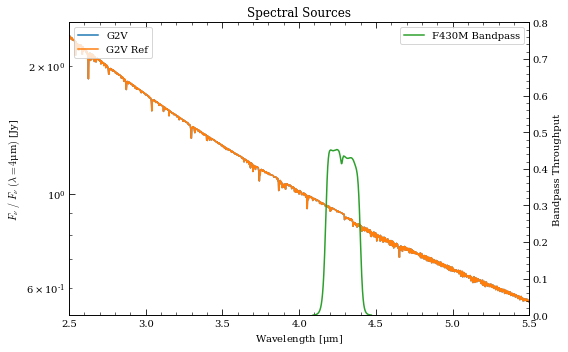

In [7]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    sp.convert('Jy')
    f = sp.flux / np.interp(4.0, w, sp.flux)
    ax.semilogy(w[ind], f[ind], lw=1.5, label=sp.name)
    ax.set_ylabel(r'$F_{\nu}~/~F_{\nu}~(\lambda=4\mathdefault{\mu m})$ [Jy]')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength [$\mathdefault{\mu m}$]')
ax.set_title('Spectral Sources')

# Overplot Filter Bandpass
bp = pynrc.read_filter('F430M', pupil='CIRCLYOT', mask='MASK430R')
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

In [8]:
bp = pynrc.read_filter('F430M')
obs = nrc_utils.S.Observation(sp_sci, bp, binset=bp.wave)
print(obs.effstim('counts')) 
print(obs.effstim('vegamag'))

95219479.90915118
3.2607771199515287


# Delivered OPD information

In [9]:
# Load OPD and other information
tvals_sec = fits.getdata(opd_dir + 'time_vector.fits') * 60

# Static OPDs
hdul_opds_static = OPDFile_to_HDUList(opd_dir + 'STATIC_NIRCAM-A_INPUT.fits')

# Thermal, frill, and IEC
hdul_opds_thermal = fits.open(opd_dir + 'TD_NIRCAM.fits')
hdul_opds_frill   = fits.open(opd_dir + 'FRILLCO_NIRCAM.fits')
hdul_opds_iec     = fits.open(opd_dir + 'IEC_NIRCAM.fits')

for hdul in [hdul_opds_static, hdul_opds_thermal, hdul_opds_frill, hdul_opds_iec]:
    for hdu in hdul:
        hdu.data *= 1e6
        hdu.header['BUNIT'] = 'micron'

# Science Observation

In [10]:
# Define detector configuration and PSF simulation
filt, mask, pupil = ('F430M', 'MASK430R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (160, 2)

# Science configuration
nrc_sci = pynrc.NIRCam(filter=filt, image_mask=mask, pupil_mask=pupil,
                       wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                       fov_pix=fov_pix, oversample=oversample)

In [11]:
# Shooting for ~3600 sec of acquisition time
nrc_sci.update_detectors(read_mode='MEDIUM8', ngroup=7, nint=50, verbose=True)

New Ramp Settings
  read_mode  :  MEDIUM8
  nf         :        8
  nd2        :        2
  ngroup     :        7
  nint       :       50
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :        0
  y0         :        0
New Ramp Times
  t_group    :   10.690
  t_frame    :    1.069
  t_int      :   72.695
  t_int_tot1 :   73.784
  t_int_tot2 :   73.784
  t_exp      : 3634.736
  t_acq      : 3689.184


In [12]:
# Turn off jitter components
nrc_sci.options['jitter'] = None
nrc_sci.options['jitter_sigma'] = 0

In [13]:
# Set target acq values
nrc_sci.options['source_offset_r'] = 0
nrc_sci.options['source_offset_theta'] = 0

In [14]:
# Create a time series of frames
det = nrc_sci.Detector
nint = det.multiaccum.nint
ngroup = det.multiaccum.ngroup

# Group times within a given integration
tg_arr = det.times_group_avg

# Repeat nint and add total integration time
tg_all = tg_arr.reshape([-1,1]).repeat(nint, axis=1)
tg_all = tg_all.transpose()
tg_all = tg_all + np.arange(nint).reshape([-1,1]) * det.time_total_int2

# Time step of integration (average)
tint_all = np.mean(tg_all, axis=1)

In [15]:
# Create drifted OPDs for each integration

# Interpolate OPDS for each integration
dopds_sci = np.zeros([nint,1024,1024])
hdul = hdul_opds_thermal
for hdul in tqdm([hdul_opds_thermal, hdul_opds_frill, hdul_opds_iec]):
    # Flip along y-axis for correct orientation
    opds = hdul[imode].data[:,::-1,:]
    func = interp1d(tvals_sec, opds, axis=0, kind='linear', bounds_error=True)

    opds_int = func(tint_all)
#     dopds_sci += np.array([zoom(opd, 1024/100) for opd in opds_int])
    dopds_sci += np.array([frebin(opd, dimensions=1024, total=False) for opd in opds_int])

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
# Create random jitter realizations for each group timestep [nint, ngroup, 2]
jitter_sig = jitter_modes[imode_jitt]
jitter_rand = np.random.normal(scale=jitter_sig, size=(nint,ngroup,2)) / 1000

In [17]:
# Create slopes for all integrations
im_slope_sci = []
for i in trange(nint):
    # Create copy of OPD and add delta
    opd_int = deepcopy(hdul_opds_static)
    opd_int[0].data += dopds_sci[i]

    im_slope = gen_slope_image(nrc_sci, opd_int, jitter_rand[i], sp=sp_sci)
    im_slope_sci.append(im_slope)
    
im_slope_sci = np.array(im_slope_sci)

# Save final OPD for input into reference
opd_sci_last = deepcopy(opd_int)

  0%|          | 0/50 [00:00<?, ?it/s]

# Reference Observation

In [36]:
# Target acquisition offset scenario
imode_tacq = 0

In [37]:
# Define detector configuration and PSF simulation
filt, mask, pupil = ('F430M', 'MASK430R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (160, 2)

# Science configuration
nrc_ref = pynrc.NIRCam(filter=filt, image_mask=mask, pupil_mask=pupil,
                       wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                       fov_pix=fov_pix, oversample=oversample)

In [38]:
# Shooting for ~3600 sec of acquisition time
nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=7, nint=50, verbose=True)

New Ramp Settings
  read_mode  :  MEDIUM8
  nf         :        8
  nd2        :        2
  ngroup     :        7
  nint       :       50
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :        0
  y0         :        0
New Ramp Times
  t_group    :   10.690
  t_frame    :    1.069
  t_int      :   72.695
  t_int_tot1 :   73.784
  t_int_tot2 :   73.784
  t_exp      : 3634.736
  t_acq      : 3689.184


In [39]:
# Turn off jitter components (performed manually)
nrc_ref.options['jitter']       = None
nrc_ref.options['jitter_sigma'] = 0

# Initial TA Offsets
ta_x, ta_y  = tacq_vals[imode_tacq] / 1000  # arcsec
ta_r, ta_th = xy_to_rtheta(ta_x, ta_y)
nrc_ref.options['source_offset_r']     = ta_r
nrc_ref.options['source_offset_theta'] = ta_th

In [40]:
# Create a time series of frames
det = nrc_ref.Detector
nint = det.multiaccum.nint
ngroup = det.multiaccum.ngroup

# Group times within a given integration
tg_arr = det.times_group_avg

# Repeat nint and add total integration time
tg_all = tg_arr.reshape([-1,1]).repeat(nint, axis=1)
tg_all = tg_all.transpose()
tg_all = tg_all + np.arange(nint).reshape([-1,1]) * det.time_total_int2

# Time step of integration (average)
tint_all = np.mean(tg_all, axis=1)

In [41]:
# Create drifted OPDs for each integration
# Start at beginning at flip sign for frill and thermal

# Interpolate OPDS for each integration
dopds_ref = np.zeros([nint,1024,1024])
hdul = hdul_opds_thermal
for hdul in tqdm([hdul_opds_thermal, hdul_opds_frill, hdul_opds_iec]):
    # Flip along y-axis for correct orientation
    opds = hdul[imode].data[:,::-1,:]
    func = interp1d(tvals_sec, opds, axis=0, kind='linear', bounds_error=True)
    
    # Flip sign for thermal and frill
    if (hdul is hdul_opds_thermal) or (hdul is hdul_opds_frill):
        opds_int = func(tint_all)
        opds_int *= -1
    else:
        # For IEC, start 3600 sec later
        opds_int = func(tint_all + nrc_sci.Detector.time_total)        
    
#     dopds_ref += np.array([zoom(opd, 1024/100) for opd in opds_int])
    dopds_ref += np.array([frebin(opd, dimensions=1024, total=False) for opd in opds_int])

  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
# Create random jitter realizations for each group timestep [nint, ngroup, 2]
jitter_sig = jitter_modes[imode_jitt]
jitter_rand_ref = np.random.normal(scale=jitter_sig, size=(nint,ngroup,2)) / 1000

In [43]:
# Create slopes for all integrations
im_slope_ref = []
for i in trange(nint):
    # Create copy of OPD and add delta
    opd_int = deepcopy(opd_sci_last)
    opd_int[0].data += dopds_ref[i]

    im_slope = gen_slope_image(nrc_ref, opd_int, jitter_rand_ref[i], sp=sp_ref)
    im_slope_ref.append(im_slope)
    
im_slope_ref = np.array(im_slope_ref)

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
# Realign reference images
tax_pix = ta_x / nrc_ref.pixelscale
tay_pix = ta_y / nrc_ref.pixelscale
im_slope_ref_sh = fourier_imshift(im_slope_ref, -tax_pix, -tay_pix, pad=False)

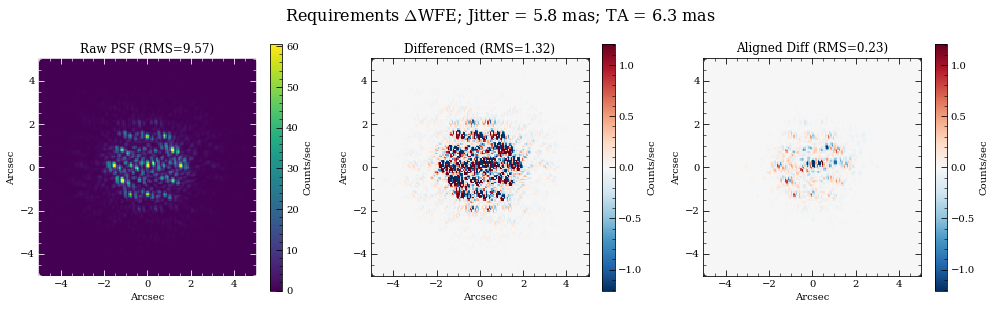

In [45]:
im_sci = np.mean(im_slope_sci, axis=0)
im_ref = np.mean(im_slope_ref, axis=0)
im_ref_sh = np.mean(im_slope_ref_sh, axis=0)

diff1 = im_sci - im_ref
diff2 = im_sci - im_ref_sh

hdul_sci   = fits.HDUList(fits.PrimaryHDU(im_sci))
hdul_diff1 = fits.HDUList(fits.PrimaryHDU(diff1))
hdul_diff2 = fits.HDUList(fits.PrimaryHDU(diff2))

# Get min/max for plotting difference images
im = hdul_diff2[0].data
im_rho = dist_image(im, pixscale=nrc_sci.pixelscale)
ind = (im_rho>1) & (im_rho<3)
vmax_diff = np.max(np.abs(im[ind]))
vmin_diff = -1 * vmax_diff

fig, axes = plt.subplots(1,3,figsize=(14,4.25))

titles = ['Raw PSF', 'Differenced', 'Aligned Diff']
for i, hdul in enumerate([hdul_sci, hdul_diff1, hdul_diff2]):
    hdul[0].header['PIXELSCL'] = nrc_sci.pixelscale
    ax = axes[i]
    
    if i==0:
        vmin = vmax = None
        axes_color='white'
        cmap = None
    else:
        vmin = vmin_diff
        vmax = vmax_diff
        axes_color='k'
        cmap = 'RdBu_r'
        
    plot_hdulist(hdul, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, axes_color=axes_color)
    
    hdu = hdul[0]
    im_rho = dist_image(hdu.data, pixscale=hdu.header['PIXELSCL'])

    rms = np.std(hdu.data[im_rho<2])
    rms_str = f' (RMS={rms:.2f})'
    ax.set_title(titles[i] + rms_str)


ta_val = tacq_vals[imode_tacq][0]
title = f'{scenarios[imode]} $\Delta$WFE; Jitter = {jitter_sig:.1f} mas; TA = {ta_val:.1f} mas'
fig.suptitle(title, fontsize=16)

fig.tight_layout()

fname = f'images_{scenarios[imode]}_jit{jitter_sig:.1f}mas_tacq{ta_val:.1f}mas.pdf'
fname = fname.replace(' ','')
fig.savefig('output/'+fname)

In [46]:
# Save files
f1 = f'{scenarios[imode]}_jit{jitter_sig:.1f}mas_tacq{ta_val:.1f}mas_psf.fits'
f1 = f1.replace(' ','')

f2 = f'{scenarios[imode]}_jit{jitter_sig:.1f}mas_tacq{ta_val:.1f}mas_diff1.fits'
f2 = f2.replace(' ','')

f3 = f'{scenarios[imode]}_jit{jitter_sig:.1f}mas_tacq{ta_val:.1f}mas_diff2.fits'
f3 = f3.replace(' ','')

hdul_sci.writeto('output/' + f1, overwrite=True)
hdul_diff1.writeto('output/' + f2, overwrite=True)
hdul_diff2.writeto('output/' + f3, overwrite=True)

In [47]:
nsig = 5

# Get standard deviation at each radial bin
rr, stds = radial_std(diff2, pixscale=nrc_sci.pixelscale)

# Bin to detector-sampled data
xpix, ypix = (nrc_sci.det_info['xpix'], nrc_sci.det_info['ypix'])
pixscale = nrc_sci.pixelscale

ny, nx = (ypix, xpix)
yv = (np.arange(ny) - ny/2) * pixscale
xv = np.zeros_like(yv)

# Get mask transmission
trans = nrc_mask_trans(nrc_sci.image_mask, xv, yv)
# Linear combination of min/max to determine PSF max value at given distance
# Get a and b values for each position
avals = trans**2
bvals = 1 - avals

bp = nrc_sci.bandpass
obs = nrc_utils.S.Observation(sp_sci, bp, binset=bp.wave)
star_flux = obs.effstim('counts')
psf_cen = pad_or_cut_to_size(im_sci / star_flux, 20)
psf_off = nrc_ref.calc_psf_from_coeff(use_bg_psf=True, return_oversample=False, 
                                      return_hdul=False)

psf_cen_max = psf_cen.max()
psf_off_max = psf_off.max()

# Linear combination
psf_max = avals * psf_off_max + bvals * psf_cen_max
# Interpolate values at rr locations
psf_max = 10**np.interp(rr, yv, np.log10(psf_max))
# Fix anything outside of bounds
if rr.max() > 10:
    psf_max[rr>10] = psf_max[(rr>5) & (rr<10)].max()
    
# Count rate necessary to obtain some nsig
texp  = nrc_sci.multiaccum_times['t_exp']
p     = 1 / texp
crate = (p*nsig**2 + nsig*np.sqrt((p*nsig)**2 + 4*stds**2)) / 2
# Get total count rate
crate /= psf_max

# Get contrast
star_mag = obs.effstim('vegamag')
contrast = crate / star_flux
sen_mag = star_mag - 2.5*np.log10(contrast)

# Background sensitivity
sen, _ = nrc_sci.sensitivity(sp=sp_sci, nsig=nsig, units='vegamag')
bg_sen = 10**((star_mag - sen['sensitivity']) / 2.5)
bg_sen_arr = np.ones_like(rr)*bg_sen

In [48]:
# Save arrays to disk
fout = f'{scenarios[imode]}_jit{jitter_sig:.1f}mas_tacq{ta_val:.1f}mas_contrast.npz'
fout = fout.replace(' ','')

np.savez('output/' + fout, rr=rr, contrast=contrast, sen_mag=sen_mag, bg_sen_arr=bg_sen_arr)

# Load by:
#   res = np.load('output/' + fout)
# Then access:
#   rr = res['rr']

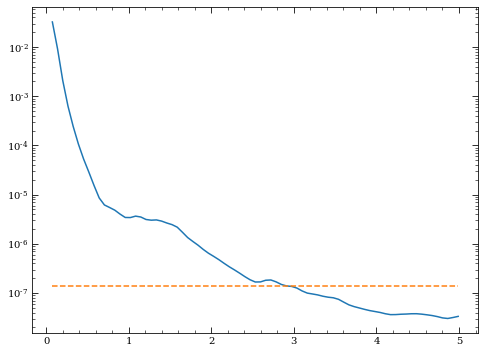

In [49]:
plt.semilogy(rr, contrast)
plt.plot(rr, bg_sen_arr, ls='--')
# plt.ylim([24,8])